# Section 04
## Exercise 04.2
A system of molecules will be evolved from three different configurations (gas, liquid, solid) characterized by:
- solid: $\rho^\star = 1.1$, $\mathrm{T}^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid: $\rho^\star = 0.8$, $\mathrm{T}^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas: $\rho^\star = 0.05$, $\mathrm{T}^\star = 1.2$ (cut-off radius: $r_c = 5.0$).

The simulation is carried out on 108 particles using a temporal step size of $\delta t^\star = 0.0005$, and estimates are computed on blocks of size 2000.
All the variables use reduced units.
The block estimates of the internal, potential and kinetic energy per-molecule (respectively $\mathrm{E}^\star/\mathrm{N}$, $\mathrm{U}^\star/\mathrm{N}$ and $\mathrm{K}^\star/\mathrm{N}$), temperature ($\mathrm{T}^\star$) and pressure ($\mathrm{p}^\star$) will be shown.

In [1]:
import subprocess as proc
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("notebook", "whitegrid", rc={"figure.dpi": 130})

# Data directory root
ROOT = Path("..")

# Base directory for the random generator seed and primes files
RNG_DIR = ROOT / "data"
# Directory in which run results are/will be stored
DATA_DIR = ROOT / "results" / "04"

EX = "04_2"

# Path to the EXECUTABLE
EXECUTABLE = ROOT / "bin" / EX
INITIAL_CONFIGURATION = "fcc"
T_TARGETS = {"liquid": 1.1, "solid": 0.8, "gas": 1.2}
ELEMENT = "argon"
VARIABLES = ["U/N", "K/N", "E/N", "T", "p"]
SETTINGS_DIR = Path.cwd() / ELEMENT


def settings_path(phase, step):
    """Path of the simulation settings for the given phase and simulation step
    """
    return SETTINGS_DIR / step / f"input.{phase}"


def output_dir(phase, step):
    """Directory where simulation results for the given phase and step will be stored
    """
    return DATA_DIR / phase / step


def seed_path_from(phase, step=None):
    if step is None:
        return RNG_DIR / "seeds" / "seed.in"
    else:
        return output_dir(phase, step) / "rng.seed"


def config_path_from(phase, step=None):
    """Path to the position configuration for the given phase and step
    """
    if step is None:
        return SETTINGS_DIR / f"config.{INITIAL_CONFIGURATION}"
    else:
        return output_dir(phase, step) / "config.positions"


def velocities_path_from(phase, step=None):
    """Path to the velocity configuration for the given phase and step
    """
    if step is None:
        return ""
    else:
        return output_dir(phase, step) / "config.velocities"


def load(phase, step):
    df = pd.read_csv(output_dir(phase, step) / "thermo.csv").rename(
        columns=(lambda label: tuple(label.split("_", 1)))
    )
    df.columns = pd.MultiIndex.from_tuples(df.columns)
    return df


def load_and_plot1(phase, step, expected_T, axes, which):
    df = load(phase, step)
    for var, ax in zip(VARIABLES, axes.flatten()):
        df[var].plot.line(y=which, yerr="error", ax=ax, legend=False)
    axes[3].axhline(expected_T, color="red")

def load_and_plot2(phase, step, expected_T, which):
    df = load(phase, step)
    fig, axes = plt.subplots(
        3, 2, sharex=True, figsize=(8, 12), constrained_layout=True
    )
    for var, ax in zip(VARIABLES, axes.flatten()):
        df[var].plot.line(y=which, yerr="error", ax=ax, legend=False)
        ax.set_title(var)
    axes[2, 1].set_axis_off()
    axes[1, 1].axhline(expected_T, color="red")
    fig.suptitle(f"{ELEMENT.capitalize()}, {phase}")
    return axes

def perform_simulation(phase, step_spec, use_cached):
    """Performs an MD simulation using settings and configurations saved in the filesystem.

    Args:
        phase (string): Tag for the simulation and system settings. Instructions in folder ELEMENT/<current_step>/input.<phase> will be used.
        step_spec (Tuple[Optional[string], string]): A pair informing whether to resume from a previous step and the current step name.\
            Setting the first member to `None` instructs to start from a default configuration, while providing \
            a string "prev_step_tag" makes the program resume the position and velocity configurations in \
            `output_dir(phase, "prev_step_tag")`. \
            The second member "step_tag" tells the program to use the simulation settings in `settings_path(phase, "step_tag")` \
            and to store results in òutput_dir(phase, "step_tag")`.
    """
    from_step, current_step = step_spec
    if use_cached and (output_dir(phase, current_step) / "thermo.csv").exists():
        return
    n = 0 if "warmup" in current_step else 10
    return proc.run(
                [
                    EXECUTABLE,
                    f"--primes_path={RNG_DIR/'primes'/'Primes'}",
                    f"--seeds_path={seed_path_from(phase, from_step)}",
                    f"--primes_line=15",
                    f"--out={output_dir(phase, current_step)}",
                    f"--configuration={config_path_from(phase, from_step)}",
                    f"--velocities={velocities_path_from(phase, from_step)}",
                    f"--settings={settings_path(phase, current_step)}",
                    f"--save_every={n}",
                ]
            )

In [2]:
# Whether to run the program or use cached results
USE_CACHED = True

PHASES = ["gas", "liquid", "solid"]

# Simulation steps specifications. This list's elements are pairs with the step
# you want to start from and the step you are performing.
steps = [(None, "warmup"), ("warmup", "run")]

res =  []
for from_step, current_step in steps:
    for phase in PHASES:
        print(f"Running simulation of the {phase} phase")
        res.append(perform_simulation(phase, (from_step, current_step), USE_CACHED))

for phase in PHASES:
    print(f"Using results from {output_dir(phase, steps[-1][1]) / 'thermo.csv'}")


Running simulation of the gas phase
[================================================================================] :52s<00m:00s] 
Running simulation of the liquid phase
[================================================================================] :30s<00m:00s] 
Running simulation of the solid phase
[================================================================================] :11s<00m:00s] 
Running simulation of the gas phase
[================================================================================] :37s<00m:00s] 
Running simulation of the liquid phase
[================================================================================] :57s<00m:00s] 
Running simulation of the solid phase
[================================================================================] :50s<00m:00s] 
Using results from ../results/04/gas/run/thermo.csv
Using results from ../results/04/liquid/run/thermo.csv
Using results from ../results/04/solid/run/thermo.csv


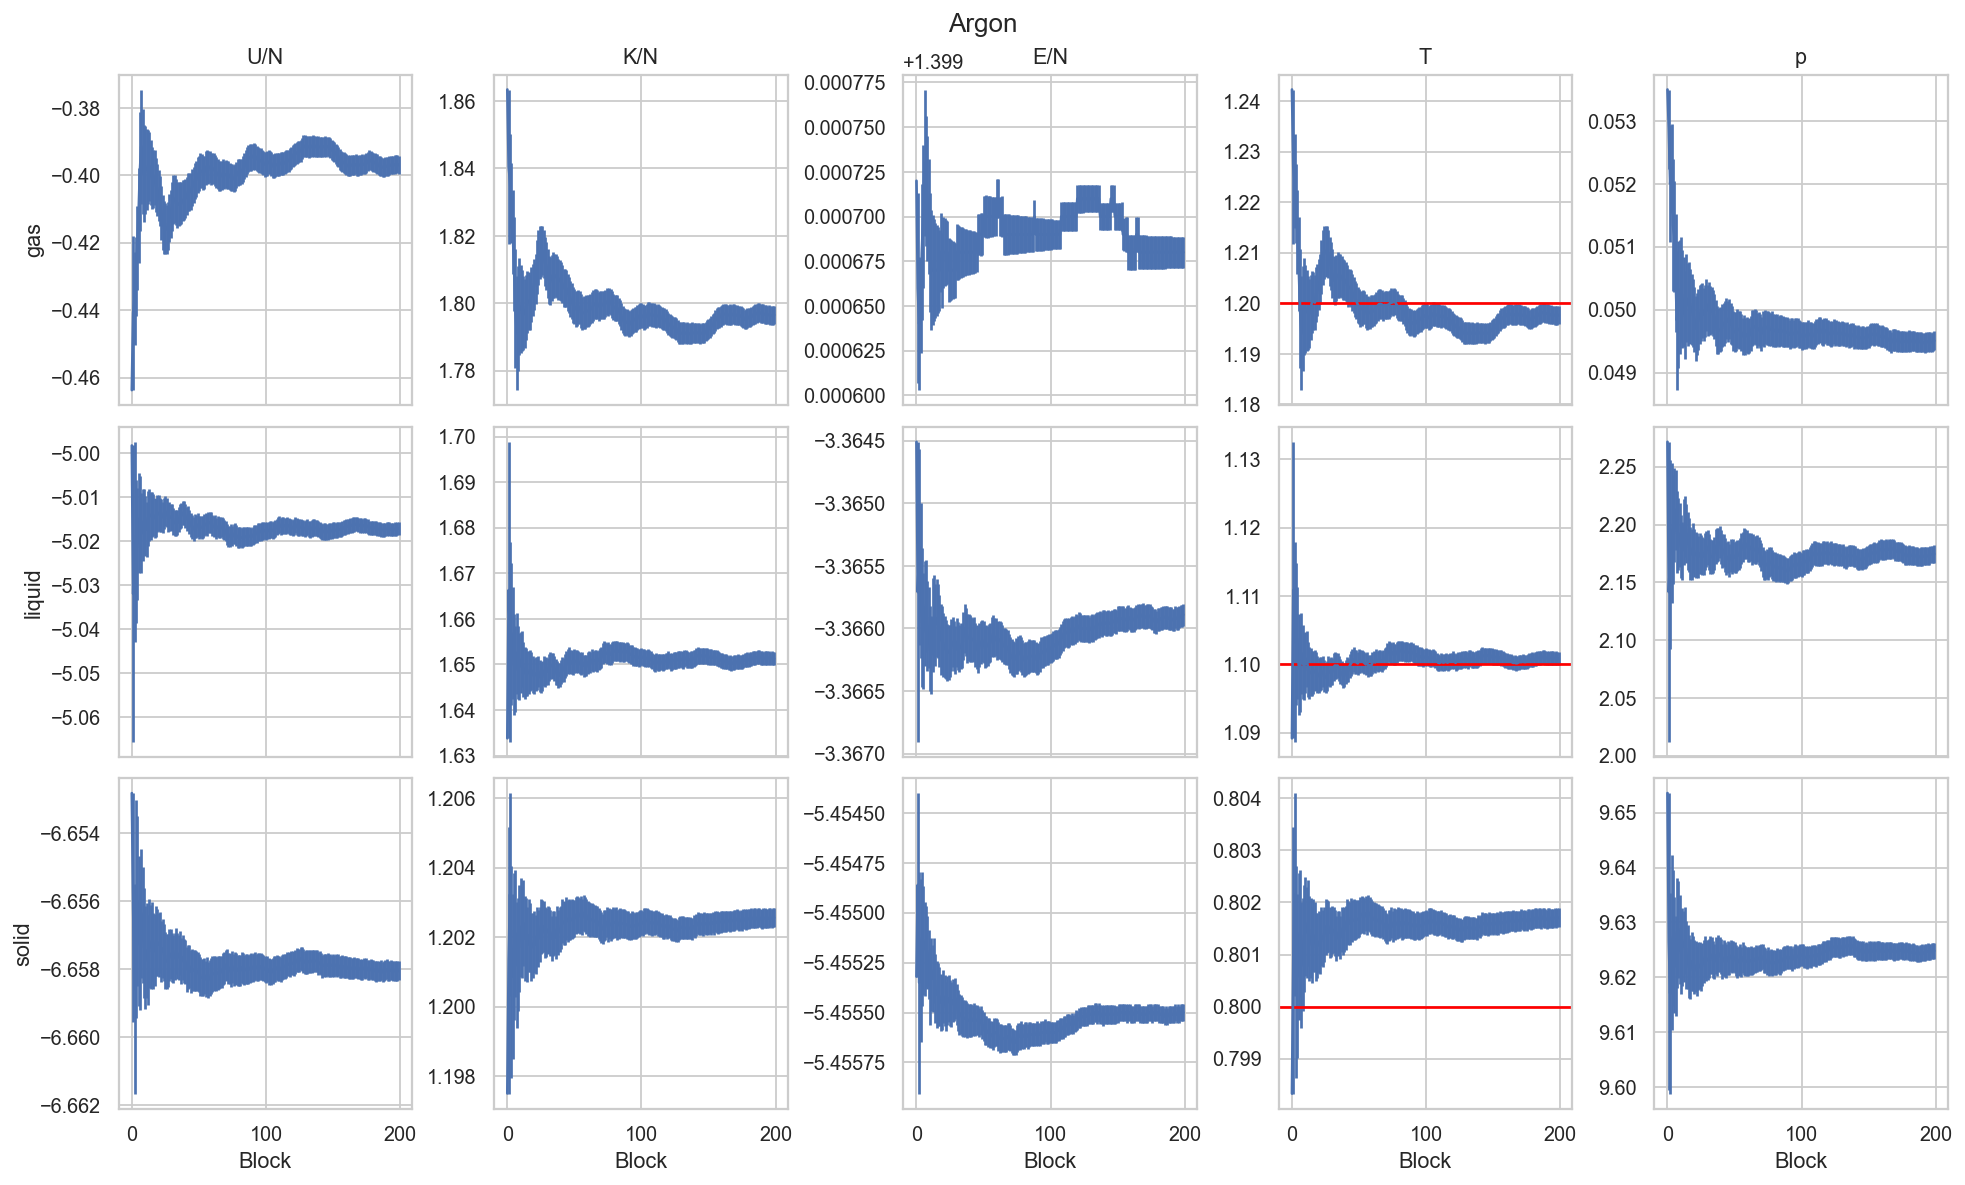

In [3]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9), constrained_layout=True, sharex=True)
for axs, phase in zip(axes, PHASES):
    load_and_plot1(phase, "run", T_TARGETS[phase], axs, "progmean")
for ax, var in zip(axes[0], VARIABLES):
    ax.set_title(var)
for ax, phase in zip(axes, PHASES):
    ax[0].set_ylabel(phase)
for ax in axes[-1]:
    ax.set_xlabel("Block")
_ = fig.suptitle("Argon")

The plots above show the thermodynamical properties of a system of molecules in gaseous, liquid and solid phases after a warmup period. The systems have reached equilibrium, as shown by the total energies.
Warmup consisted of 2000 blocks of 2000 steps, while the run itself is performed on 200 steps.